# MAE 271: Lab 1 - Quarter car simulation over bump
### Cooper Cook & Joshua Booth

### Introduction
The below graphics show the quarter car model with associated bond graph and descriptive equations for the system itself. The bump diagram is also drawn and the descriptive equations for that modeling are shown as well. The goal of the following lab project to follow is to analyze this system for both linear and non-linear spring functions. As well as varying parameters of bump-height and car velocity to display the differences in responses to the spring characteristics in the system. 

![alt text](IMG_0967.jpg)


![alt text](IMG_0968.jpg)

### Code and figures

Define global parameters and initial conditions for the system.

In [36]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# -----------------------------
# Global Parameters
# -----------------------------
mt = 3500 / 2.2            # total mass [kg]
msmus = 5                 # sprung/unsprung mass ratio
mus = mt / (1 + msmus)    # unsprung mass [kg]
ms = mt - mus             # sprung mass [kg]

ks = ms * (2 * np.pi * 1)**2        # suspension stiffness
bs = 2 * 0.5 * np.sqrt(ks * ms)     # suspension damping
kt = mus * (2 * np.pi * 8)**2       # tire stiffness
g = 9.8                             # gravity [m/s^2]

# Road input parameters
# A and u are varying or each section
d = 3 * 0.3048          # bump length [m]

# Time span
t_span = (0, 1)
t_eval = np.arange(0, 1.001, 0.001)


### Bump height A = 2in 
All simulations run with same bump height but varying car speeds (20, 25, 30mph) and tested with linear and non-linear spring models (0,1). Three figures are produced to plot the sprung mass acceleration, relative displacement of the suspension, and tire force experienced by going over the bump.

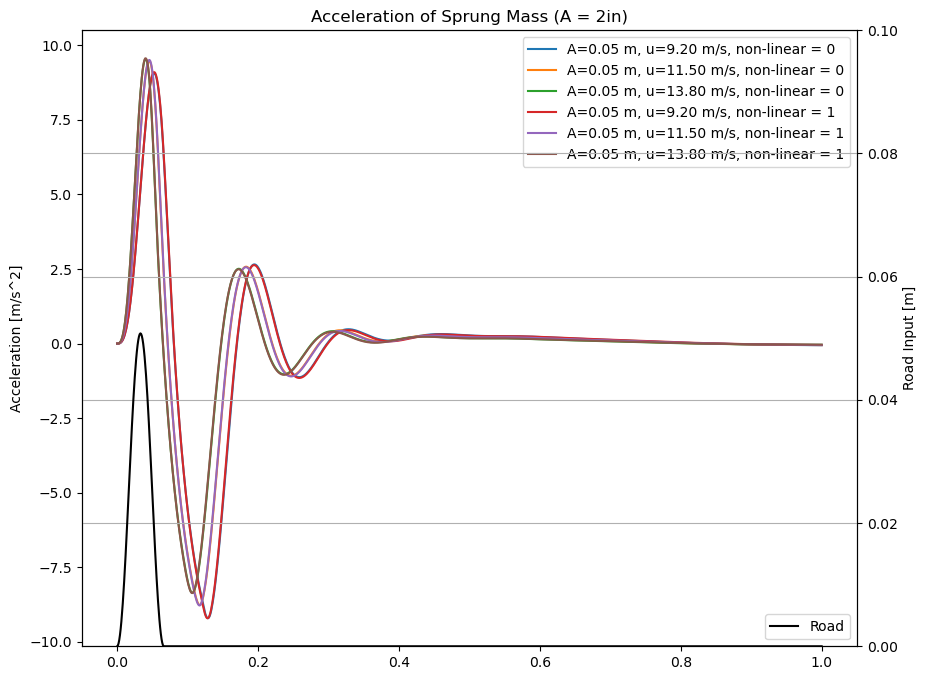

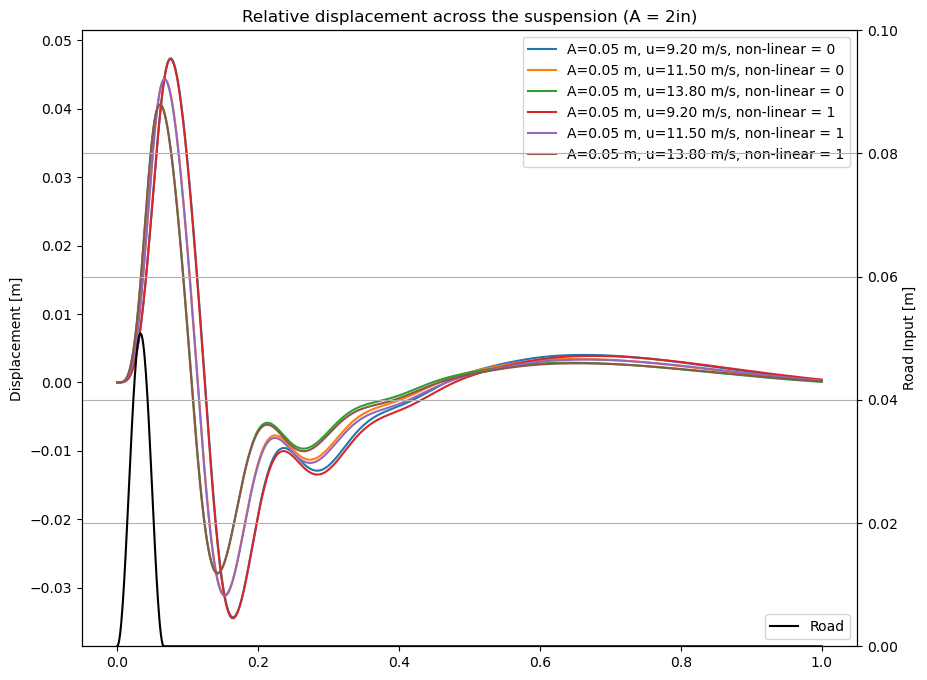

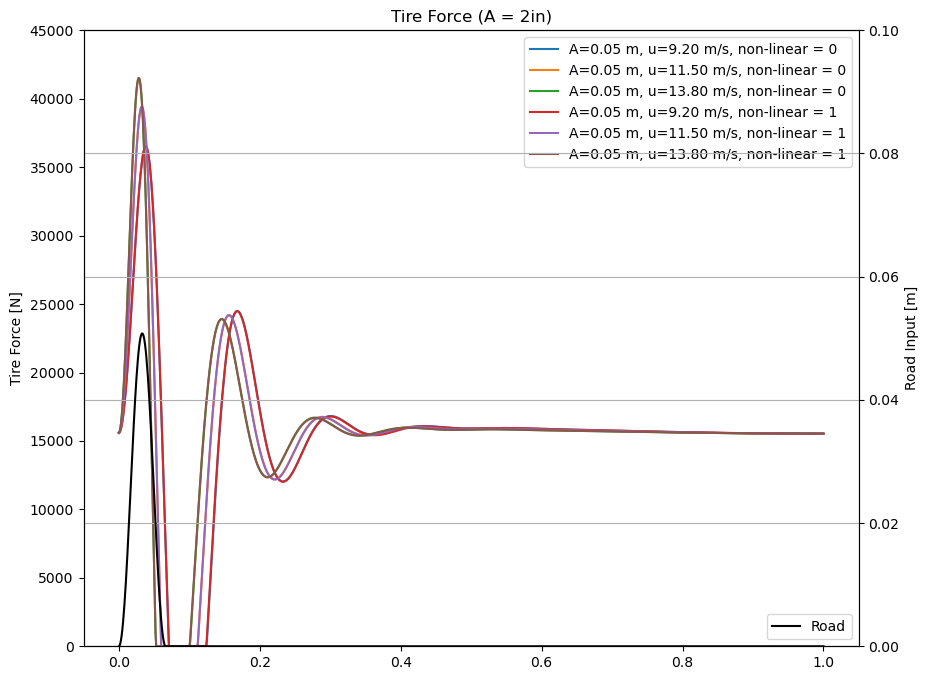

In [ ]:
# A = 2in bump height
for A in [2*0.0254]:   # Set bump height (convert in to m)
    results_A_2 = []  # store all simulation cases
    for n in [0,1]:
        # Nonlinear spring 
        G = (ks / (3 * (ms * g)**(2/3)))**3

        # Initial conditions: [ps, pus, qs, qt]
        if n == 1:
            initial = [0, 0, (ms * g / G)**(1/3), mt * g / kt]
        else:
            initial = [0, 0, 1.0 * ms * g / ks, mt * g / kt]

        for u in [20*0.46, 25*0.46, 30*0.46]:  # Loop through varying car speeds for each bump height (convert mph to m/s)

            # Model Function
            def LabDemoFunc(t, s):
                ps, pus, qs, qt = s

                # Road input
                X = u * t
                Y = 0.5 * A * (1 - np.cos(2 * np.pi * X / d))
                dYdX = 0.5 * A * (2 * np.pi / d) * np.sin(2 * np.pi * X / d)

                if X > d:
                    Y = 0
                    dYdX = 0

                vin = u * dYdX

                # Tire force
                Ft = kt * qt
                if qt <= 0:
                    Ft = 0

                # Velocities
                vs = ps / ms
                vus = pus / mus

                # Spring force
                if n == 1:
                    Fs = G * qs**3 + bs * (vus - vs)
                    Fss = G * qs**3
                else:
                    Fs = ks * qs + bs * (vus - vs)
                    Fss = ks * qs

                # State derivatives
                dps = -ms * g + Fs
                dpus = -mus * g + Ft - Fs
                dqs = vus - vs
                dqt = vin - vus

                ds = [dps, dpus, dqs, dqt]
                ext = [X, Y, Ft, vs, vus, vin, Fss]

                return ds, ext

            # Wrapper for solver
            def ode_wrapper(t, s):
                ds, _ = LabDemoFunc(t, s)
                return ds

            # -----------------------------
            # Run Simulation
            # -----------------------------
            sol = solve_ivp(ode_wrapper, t_span, initial, t_eval=t_eval)

            t = sol.t
            s = sol.y.T

            # Extract states
            ps, pus, qs, qt = s.T

            # Compute extra outputs
            ext = np.zeros((len(t), 7))
            ds = np.zeros((len(t), 4))

            for i in range(len(t)):
                ds[i], ext[i] = LabDemoFunc(t[i], s[i])

            dps, dpus, dqs, dqt = ds.T
            X, Y, Ft, vs, vus, vin, Fss = ext.T

            # Store results
            results_A_2.append({
                "A": A,
                "u": u,
                "t": t,
                "ps": ps,
                "pus": pus,
                "qs": qs,
                "qt": qt,
                "X": X,
                "Y": Y,
                "Ft": Ft,
                "vs": vs,
                "vus": vus,
                "vin": vin,
                "Fss": Fss,
                "dps": dps,
                "ms": ms,
                "lin": n
            })

    # Plot Results

    # Sprung masss acceleration
    plt.figure(figsize=(10,8))
    for r in results_A_2:
        label = f"A={r['A']:.2f} m, u={r['u']:.2f} m/s, non-linear = {r['lin']}"
        plt.plot(r["t"], (r["dps"]/r["ms"]), label=label)
        plt.ylabel("Acceleration [m/s^2]")
        plt.legend()

    plt.twinx()
    plt.plot(t, Y, label="Road", color="k")
    plt.ylabel("Road Input [m]")
    plt.xlabel("Time (s)")
    plt.ylim(0,0.10)
    plt.legend(loc='lower right')
    plt.title('Acceleration of Sprung Mass (A = 2in)')
    plt.grid(True)
    plt.show()

    # Relative displacement across the suspension
    plt.figure(figsize=(10,8))
    for r in results_A_2:
        label = f"A={r['A']:.2f} m, u={r['u']:.2f} m/s, non-linear = {r['lin']}"
        plt.plot(r["t"], (r["qs"]-r["qs"][0]), label=label)
        plt.ylabel("Displacement [m]")
        plt.legend()

    plt.twinx()
    plt.plot(t, Y, label="Road", color="k")
    plt.ylabel("Road Input [m]")
    plt.xlabel("Time (s)")
    plt.ylim(0,0.10)
    plt.legend(loc='lower right')
    plt.title('Relative displacement across the suspension (A = 2in)')
    plt.grid(True)
    plt.show()

    # Tire force
    plt.figure(figsize=(10,8))
    for r in results_A_2:
        label = f"A={r['A']:.2f} m, u={r['u']:.2f} m/s, non-linear = {r['lin']}"
        plt.plot(r["t"], (r["Ft"]), label=label)
        plt.ylabel("Tire Force [N]")
        plt.ylim(0,45000)
        plt.legend()

    plt.twinx()
    plt.plot(t, Y, label="Road", color="k")
    plt.ylabel("Road Input [m]")
    plt.xlabel("Time (s)")
    plt.ylim(0,0.10)
    plt.legend(loc='lower right')
    plt.title('Tire Force (A = 2in)')
    plt.grid(True)
    plt.show()

As seen above all three car speeds and with linear (0) and non-linear (1) springs are plotted on the same figures above. Due to the small bump height there is almost no difference between the different speeds and spring models displayed. This is especially true for the acceleration and tire force plots. There is more distinguishment between the linear and non-linear spring in the relative displacement plot around the t = 0.3-0.6s timeframe. 

### Bump Height A = 4in
Same figures and procedure followed below.

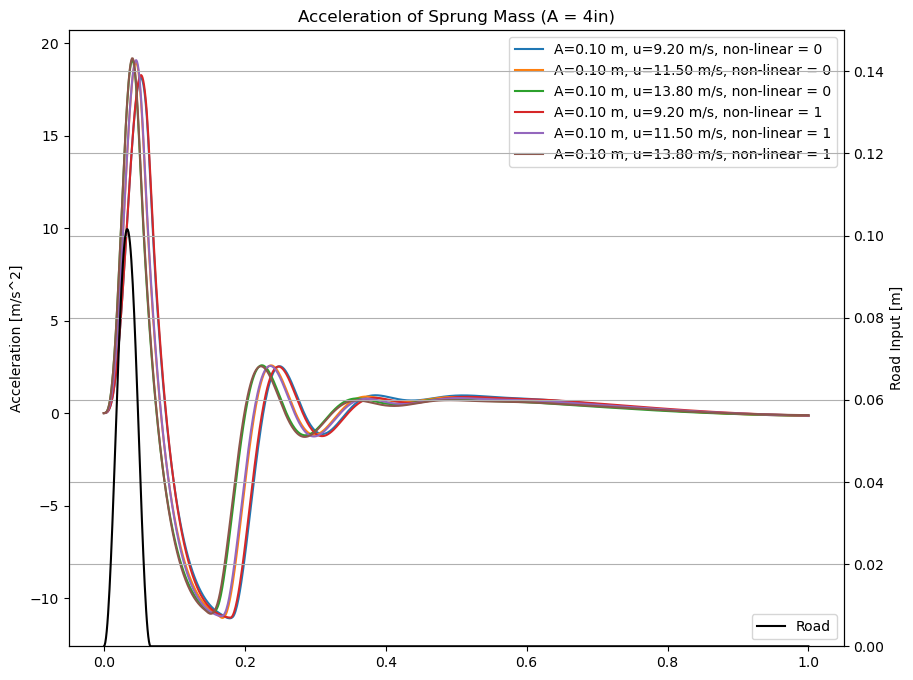

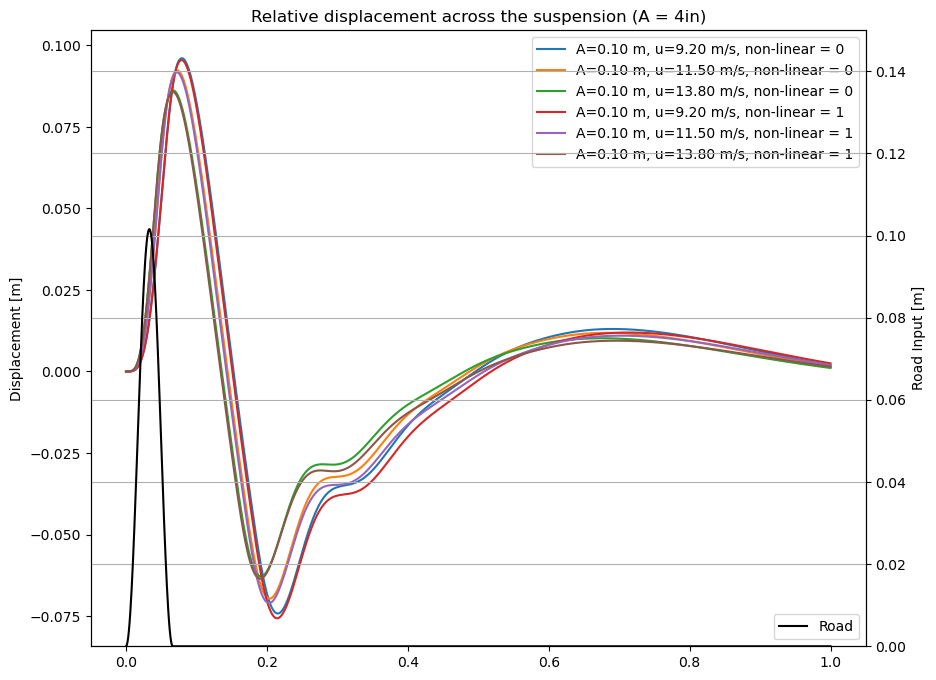

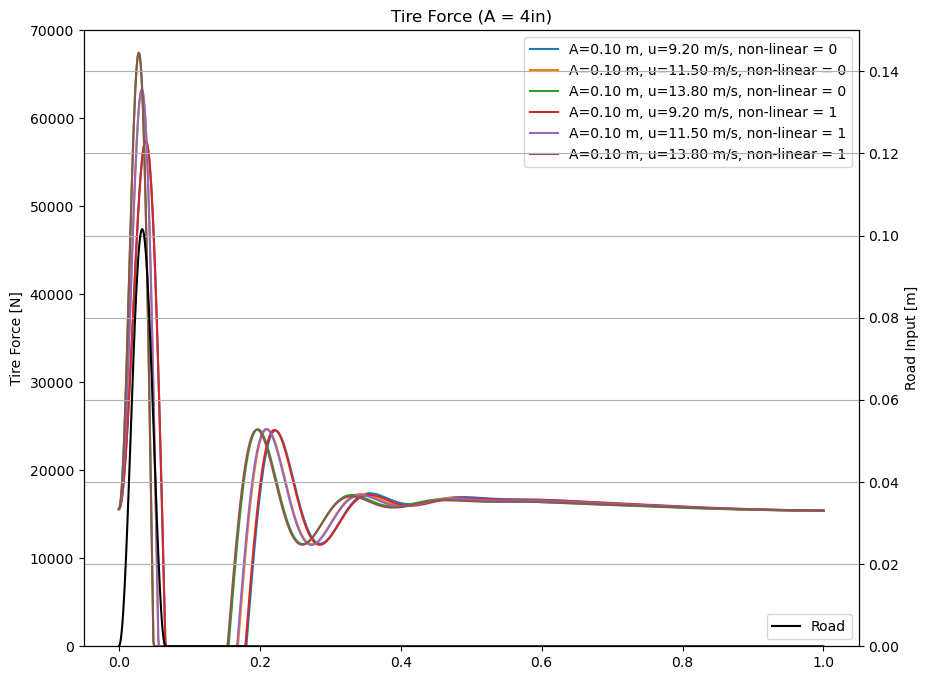

In [ ]:
# A = 4in bump height
for A in [4*0.0254]:   # Loop through varying bump heights 
    results_A_4 = []
    for n in [0,1]:
        # Nonlinear spring toggle
        G = (ks / (3 * (ms * g)**(2/3)))**3

        # Initial conditions: [ps, pus, qs, qt]
        if n == 1:
            initial = [0, 0, (ms * g / G)**(1/3), mt * g / kt]
        else:
            initial = [0, 0, 1.0 * ms * g / ks, mt * g / kt]

        for u in [20*0.46, 25*0.46, 30*0.46]:  # Loop through varying car speeds for each bump height
            # -----------------------------
            # Model Function
            # -----------------------------
            def LabDemoFunc(t, s):
                ps, pus, qs, qt = s

                # Road input
                X = u * t
                Y = 0.5 * A * (1 - np.cos(2 * np.pi * X / d))
                dYdX = 0.5 * A * (2 * np.pi / d) * np.sin(2 * np.pi * X / d)

                if X > d:
                    Y = 0
                    dYdX = 0

                vin = u * dYdX

                # Tire force
                Ft = kt * qt
                if qt <= 0:
                    Ft = 0

                # Velocities
                vs = ps / ms
                vus = pus / mus

                # Spring force
                if n == 1:
                    Fs = G * qs**3 + bs * (vus - vs)
                    Fss = G * qs**3
                else:
                    Fs = ks * qs + bs * (vus - vs)
                    Fss = ks * qs

                # State derivatives
                dps = -ms * g + Fs
                dpus = -mus * g + Ft - Fs
                dqs = vus - vs
                dqt = vin - vus

                ds = [dps, dpus, dqs, dqt]
                ext = [X, Y, Ft, vs, vus, vin, Fss]

                return ds, ext

            # Wrapper for solver
            def ode_wrapper(t, s):
                ds, _ = LabDemoFunc(t, s)
                return ds

            # -----------------------------
            # Run Simulation
            # -----------------------------
            sol = solve_ivp(ode_wrapper, t_span, initial, t_eval=t_eval)

            t = sol.t
            s = sol.y.T

            # Extract states
            ps, pus, qs, qt = s.T

            # Compute extra outputs
            ext = np.zeros((len(t), 7))
            ds = np.zeros((len(t), 4))

            for i in range(len(t)):
                ds[i], ext[i] = LabDemoFunc(t[i], s[i])

            dps, dpus, dqs, dqt = ds.T
            X, Y, Ft, vs, vus, vin, Fss = ext.T

            # Store results

            results_A_4.append({
                "A": A,
                "u": u,
                "t": t,
                "ps": ps,
                "pus": pus,
                "qs": qs,
                "qt": qt,
                "X": X,
                "Y": Y,
                "Ft": Ft,
                "vs": vs,
                "vus": vus,
                "vin": vin,
                "Fss": Fss,
                "dps": dps,
                "ms": ms,
                "lin": n
            })

    # Plot Results

    # Sprung masss acceleration
    plt.figure(figsize=(10,8))
    for r in results_A_4:
        label = f"A={r['A']:.2f} m, u={r['u']:.2f} m/s, non-linear = {r['lin']}"
        plt.plot(r["t"], (r["dps"]/r["ms"]), label=label)
        plt.ylabel("Acceleration [m/s^2]")
        plt.legend()

    plt.twinx()
    plt.plot(t, Y, label="Road", color="k")
    plt.ylabel("Road Input [m]")
    plt.xlabel("Time (s)")
    plt.ylim(0,0.15)
    plt.legend(loc='lower right')
    plt.title('Acceleration of Sprung Mass (A = 4in)')
    plt.grid(True)
    plt.show()

    # Relative displacement across the suspension
    plt.figure(figsize=(10,8))
    for r in results_A_4:
        label = f"A={r['A']:.2f} m, u={r['u']:.2f} m/s, non-linear = {r['lin']}"
        plt.plot(r["t"], (r["qs"] - r["qs"][0]), label=label)
        plt.ylabel("Displacement [m]")
        plt.legend()

    plt.twinx()
    plt.plot(t, Y, label="Road", color="k")
    plt.ylabel("Road Input [m]")
    plt.xlabel("Time (s)")
    plt.ylim(0,0.15)
    plt.legend(loc='lower right')
    plt.title('Relative displacement across the suspension (A = 4in)')
    plt.grid(True)
    plt.show()

    # Tire force
    plt.figure(figsize=(10,8))
    for r in results_A_4:
        label = f"A={r['A']:.2f} m, u={r['u']:.2f} m/s, non-linear = {r['lin']}"
        plt.plot(r["t"], (r["Ft"]), label=label)
        plt.ylabel("Tire Force [N]")
        plt.ylim(0,70000)
        plt.legend()

    plt.twinx()
    plt.plot(t, Y, label="Road", color="k")
    plt.ylabel("Road Input [m]")
    plt.xlabel("Time (s)")
    plt.ylim(0,0.15)
    plt.legend(loc='lower right')
    plt.title('Tire Force (A = 4in)')
    plt.grid(True)
    plt.show()


As the bump height increases, there is more of a notable difference between the spring models in the figures plotted above. There starts to become a little bit of separation in the acceleration plot and noticeable differences in the displacement plot as well. This is primarily attributed to a further deviation from steady state operation with an increased bump height. Due to the modeling choices of the non-linear spring, this where the differences begin to be seen. 

### Bump Height A = 6in
Same figures and procedures as followed above.

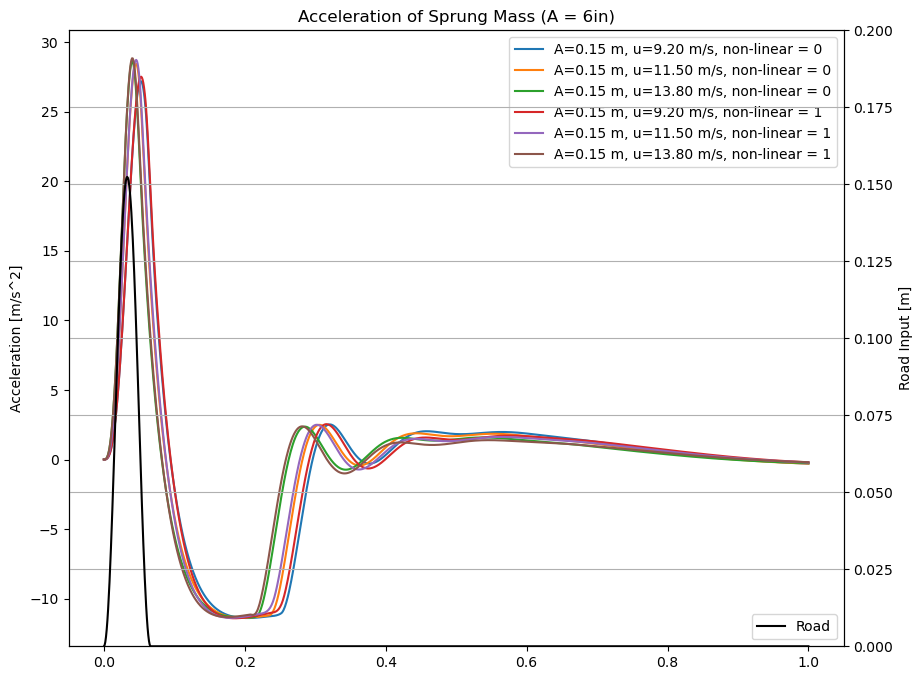

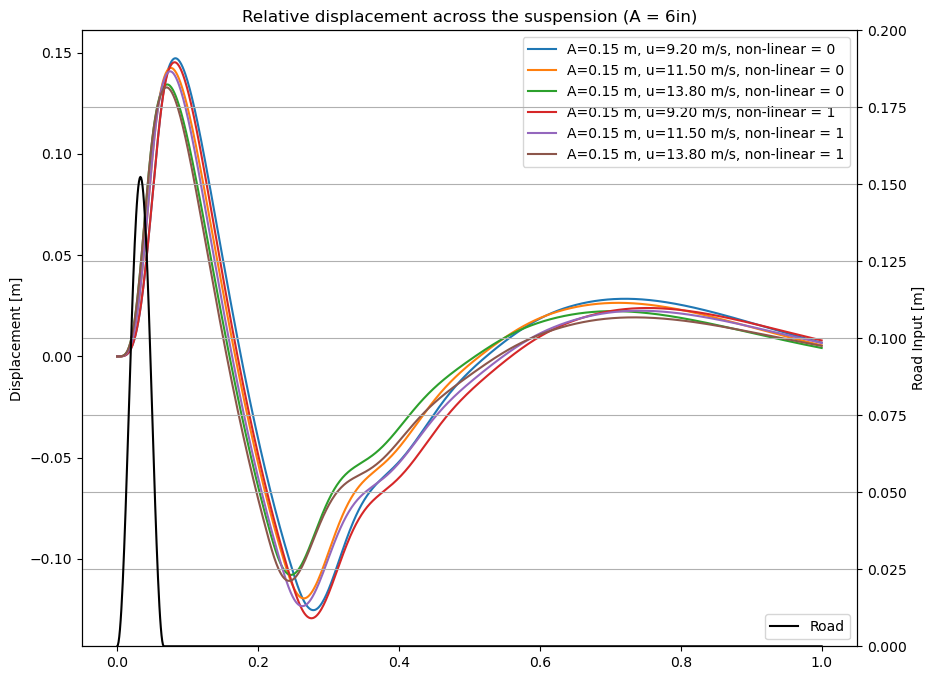

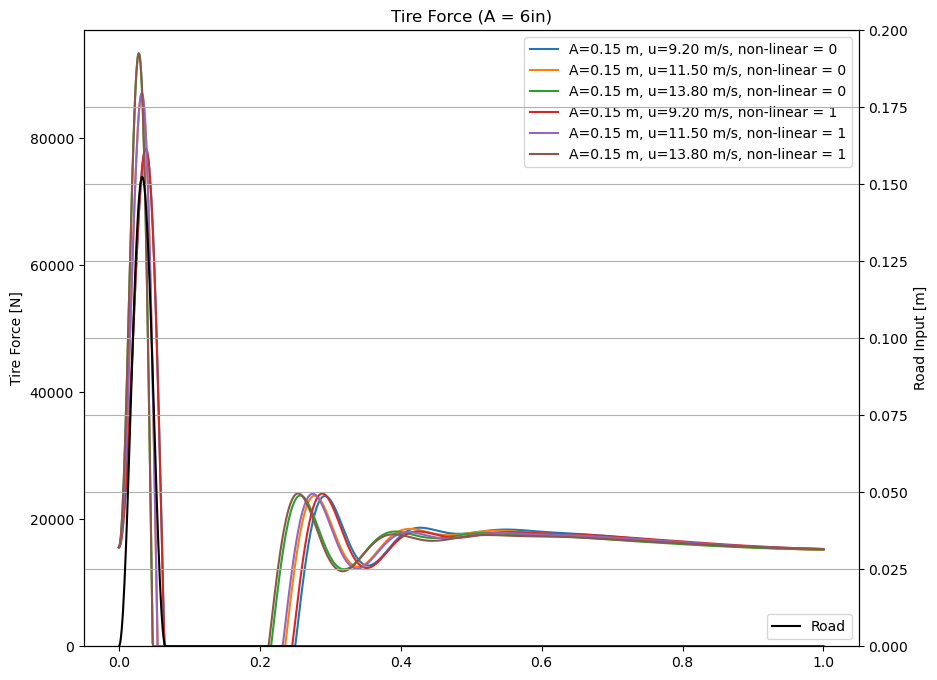

In [33]:
# A = 6in bump height
for A in [6*0.0254]:   # Loop through varying bump heights
    results_A_6 = []
    for n in [0,1]:
        # Nonlinear spring toggle
        G = (ks / (3 * (ms * g)**(2/3)))**3

        # Initial conditions: [ps, pus, qs, qt]
        if n == 1:
            initial = [0, 0, (ms * g / G)**(1/3), mt * g / kt]
        else:
            initial = [0, 0, 1.0 * ms * g / ks, mt * g / kt]

        for u in [20*0.46, 25*0.46, 30*0.46]:  # Loop through varying car speeds for each bump height
            # -----------------------------
            # Model Function
            # -----------------------------
            def LabDemoFunc(t, s):
                ps, pus, qs, qt = s

                # Road input
                X = u * t
                Y = 0.5 * A * (1 - np.cos(2 * np.pi * X / d))
                dYdX = 0.5 * A * (2 * np.pi / d) * np.sin(2 * np.pi * X / d)

                if X > d:
                    Y = 0
                    dYdX = 0

                vin = u * dYdX

                # Tire force
                Ft = kt * qt
                if qt <= 0:
                    Ft = 0

                # Velocities
                vs = ps / ms
                vus = pus / mus

                # Spring force
                if n == 1:
                    Fs = G * qs**3 + bs * (vus - vs)
                    Fss = G * qs**3
                else:
                    Fs = ks * qs + bs * (vus - vs)
                    Fss = ks * qs

                # State derivatives
                dps = -ms * g + Fs
                dpus = -mus * g + Ft - Fs
                dqs = vus - vs
                dqt = vin - vus

                ds = [dps, dpus, dqs, dqt]
                ext = [X, Y, Ft, vs, vus, vin, Fss]

                return ds, ext

            # Wrapper for solver
            def ode_wrapper(t, s):
                ds, _ = LabDemoFunc(t, s)
                return ds

            # -----------------------------
            # Run Simulation
            # -----------------------------
            sol = solve_ivp(ode_wrapper, t_span, initial, t_eval=t_eval)

            t = sol.t
            s = sol.y.T

            # Extract states
            ps, pus, qs, qt = s.T

            # Compute extra outputs
            ext = np.zeros((len(t), 7))
            ds = np.zeros((len(t), 4))

            for i in range(len(t)):
                ds[i], ext[i] = LabDemoFunc(t[i], s[i])

            dps, dpus, dqs, dqt = ds.T
            X, Y, Ft, vs, vus, vin, Fss = ext.T

            # Store results

            results_A_6.append({
                "A": A,
                "u": u,
                "t": t,
                "ps": ps,
                "pus": pus,
                "qs": qs,
                "qt": qt,
                "X": X,
                "Y": Y,
                "Ft": Ft,
                "vs": vs,
                "vus": vus,
                "vin": vin,
                "Fss": Fss,
                "dps": dps,
                "ms": ms,
                "lin": n
            })
            # print(results)

    # Plot Results

    # Sprung masss acceleration
    plt.figure(figsize=(10,8))
    for r in results_A_6:
        label = f"A={r['A']:.2f} m, u={r['u']:.2f} m/s, non-linear = {r['lin']}"
        plt.plot(r["t"], (r["dps"]/r["ms"]), label=label)
        plt.ylabel("Acceleration [m/s^2]")
        plt.legend()

    plt.twinx()
    plt.plot(t, Y, label="Road", color="k")
    plt.ylabel("Road Input [m]")
    plt.xlabel("Time (s)")
    plt.ylim(0,0.20)
    plt.legend(loc='lower right')
    plt.title('Acceleration of Sprung Mass (A = 6in)')
    plt.grid(True)
    plt.show()

    # Relative displacement across the suspension
    plt.figure(figsize=(10,8))
    for r in results_A_6:
        label = f"A={r['A']:.2f} m, u={r['u']:.2f} m/s, non-linear = {r['lin']}"
        plt.plot(r["t"], (r["qs"] - r["qs"][0]), label=label)
        plt.ylabel("Displacement [m]")
        plt.legend()

    plt.twinx()
    plt.plot(t, Y, label="Road", color="k")
    plt.ylabel("Road Input [m]")
    plt.xlabel("Time (s)")
    plt.ylim(0,0.20)
    plt.legend(loc='lower right')
    plt.title('Relative displacement across the suspension (A = 6in)')
    plt.grid(True)
    plt.show()

    # Relative displacement across the suspension
    plt.figure(figsize=(10,8))
    for r in results_A_6:
        label = f"A={r['A']:.2f} m, u={r['u']:.2f} m/s, non-linear = {r['lin']}"
        plt.plot(r["t"], (r["Ft"]), label=label)
        plt.ylabel("Tire Force [N]")
        plt.ylim(0,97000)
        plt.legend()

    plt.twinx()
    plt.plot(t, Y, label="Road", color="k")
    plt.ylabel("Road Input [m]")
    plt.xlabel("Time (s)")
    plt.ylim(0,0.20)
    plt.legend(loc='lower right')
    plt.title('Tire Force (A = 6in)')
    plt.grid(True)
    plt.show()


As expected, the largest amplitude bump height produces the largest variation in response between the linear and non-linear springs. Deviations are clear in all three figures produced above. As there is a larger deviation from steady-state assumptions, the non-linear is going to model the system more accurately as compared to a simplified linear version of the system. This also helps us visualize where simple models start to breakdown and needed complexity is to be added in order to model systems effectively. 

### Conclusions
In this lab, we modelled a quarter car system that describes how a suspension system behaves when going over a road bump at varying car speeds. Both linear and non-linear spring models were tested during these simulations to observe the differences in their modelling. As observed in the figures above, at lower bump heights the difference between spring modelling was negligible. In the plots for bump height A = 6in, the difference in the springs became clearer as we moved farther from steady-state similarities. 

This lab gave us an introduction to solving systems of ordinary differential equations that model a dynamic system. While the lab demo code was provided in MATLAB, we chose to translate the code into Python, using `scipy.integrate`'s `solveivp` function, which appeared to give the same results as the MATLAB demo code. This lab gives us a code foundation to build on for future labs.